In [52]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime

In [75]:
spy_ohlc_df = yf.download('SPY', start=datetime.date.today() - datetime.timedelta(days=7), end=datetime.date.today(), interval='1m')
df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


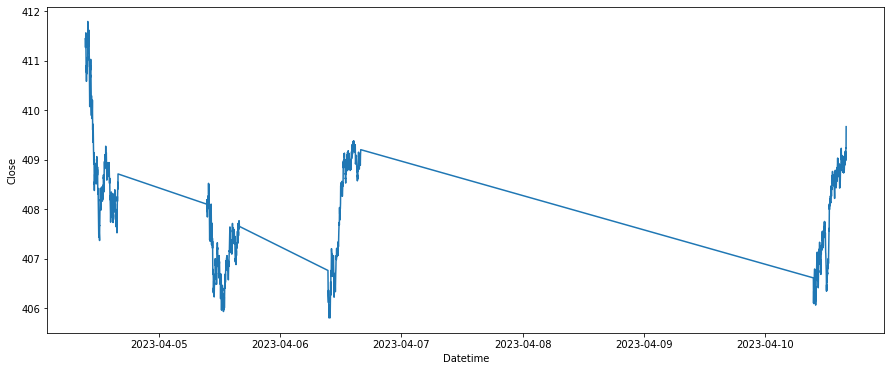

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(15,6)
sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
plt.show()

16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:29 - cmdstanpy - INFO - Chain [1] done processing


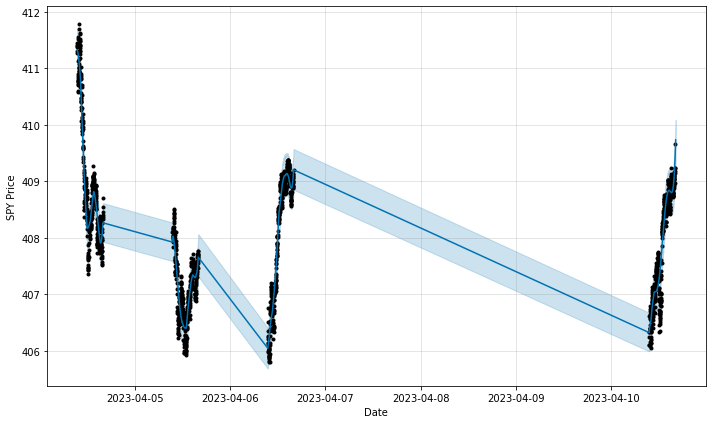

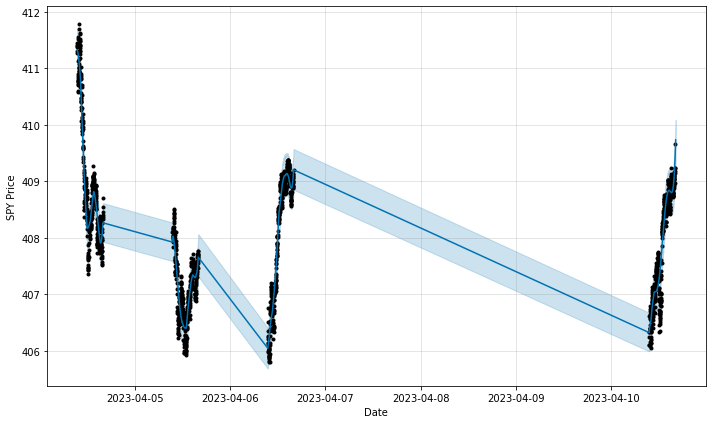

In [86]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Datetime', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=24, freq='T')
#future_dates = model.make_future_dataframe(periods=1)

# Make predictions for future dates
forecast = model.predict(future_dates)

# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')

# Plot the forecasted trend and seasonality components
model.plot_components(forecast)




16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:27 - cmdstanpy - INFO - Chain [1] done processing


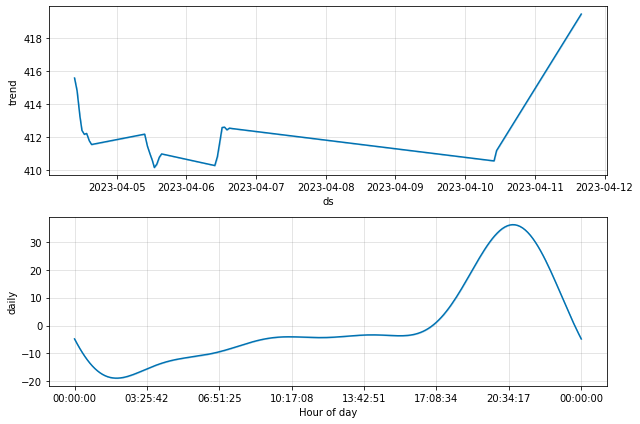

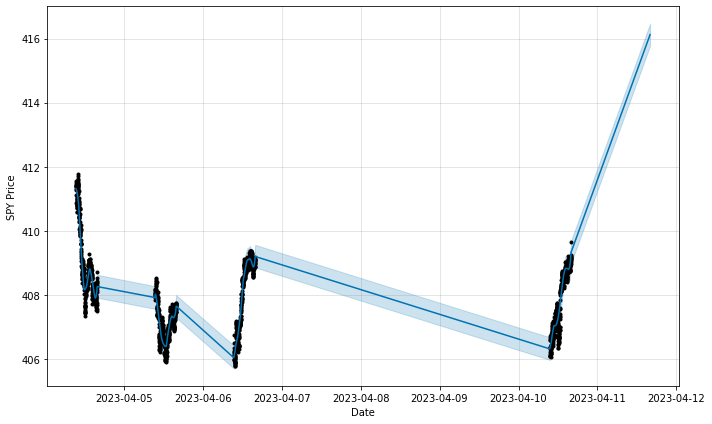

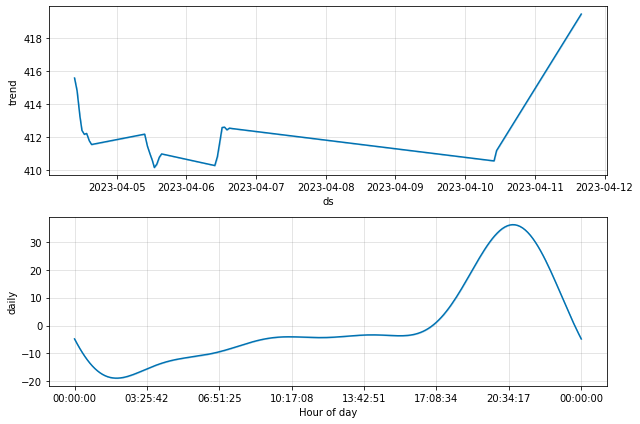

In [81]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Datetime', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
#future_dates = model.make_future_dataframe(periods=48, freq='T', include_history=False)
future_dates = model.make_future_dataframe(periods=1)

# Make predictions for future dates
forecast = model.predict(future_dates)

# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')

# Plot the forecasted trend and seasonality components
model.plot_components(forecast)




In [87]:
spy_ohlc_df = yf.download('SPY', start=datetime.date.today() - datetime.timedelta(days=1095), end=datetime.date.today())
df=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


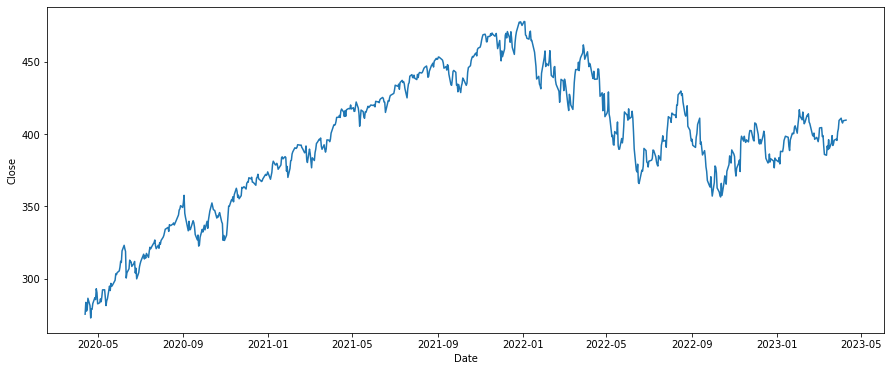

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(15,6)
sns.lineplot(x = 'Date', y = 'Close', data = df)
plt.show()

16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] done processing


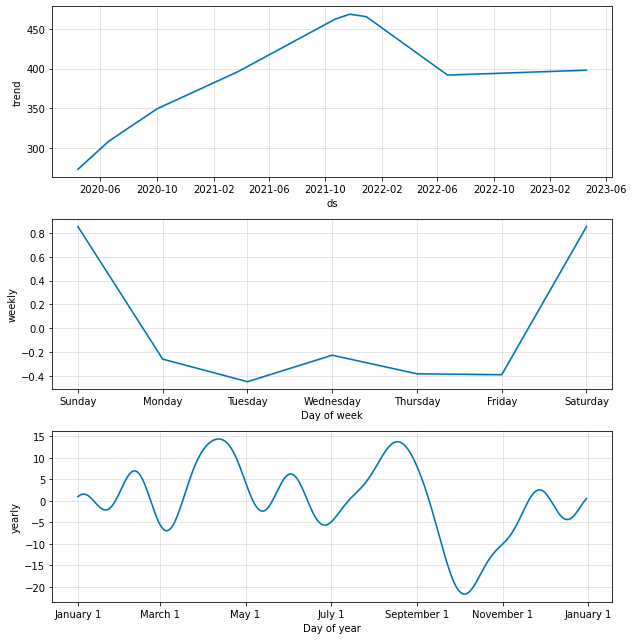

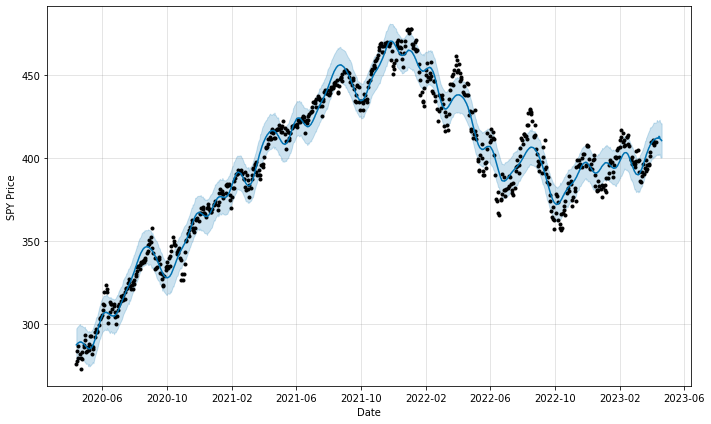

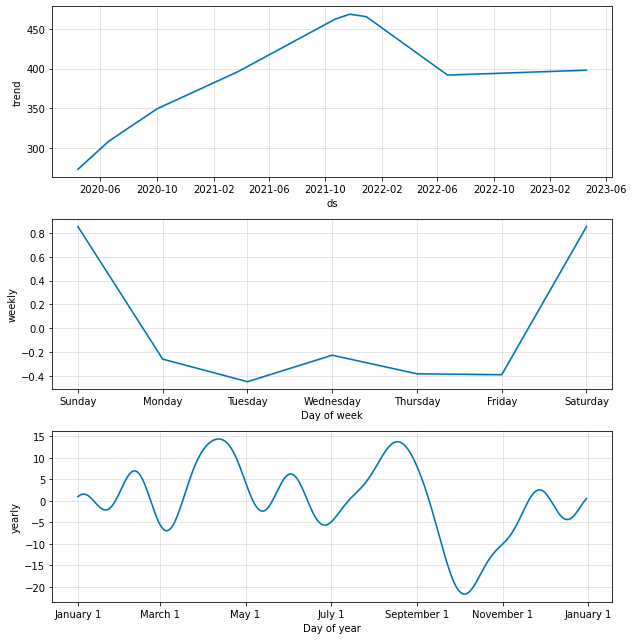

In [89]:
# Load SPY price data
spy_data = df
spy_data = df[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=10)

# Make predictions for future dates
forecast = model.predict(future_dates)

# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')

# Plot the forecasted trend and seasonality components
model.plot_components(forecast)
